In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Configurations

In [2]:
#TODO: There are many configuration parameters here. It is important to understand the effect of all.
d = 2
coeff_var = 1

Sigma_x_p1 = np.eye(d)
Sigma_x_p2 = np.eye(d)

sigma_y_p1 = 0
sigma_y_p2 = 0

beta_p1 = np.random.normal(size=d)
beta_p2 = np.random.normal(size=d)

mu_p1 = np.random.normal(scale=coeff_var, size=d)
mu_p2 = np.random.normal(scale=coeff_var, size=d)
gamma_p1 = np.random.normal(scale=coeff_var, size=d)
gamma_p2 = np.random.normal(scale=coeff_var, size=d)

#Fixing mu and gamma for testing purposes
if False:
    mu_p2 = np.array([2.1, -1.8])
    gamma_p2 = np.array([1.2, 0.9])
    mu_p1 = np.array([-2.8, 2.2])
    gamma_p1 = np.array([0.7, -0.3])

if False:
    mu_p1 = np.array([0, 0])
    gamma_p1 = np.array([1, 1])
    mu_p2 = np.array([0, 0])
    gamma_p2 = np.array([1, 1])

In [3]:
p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

In [4]:
num_rounds_lst = [10, 100, 1000, 10000, 40000, 100000]
num_alternate_rounds = 50
num_test = 10000

# Run Game

In [5]:
#Initialize game with configurations specified above
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    player_two = TwoStagePlayer()
    player_one = TwoStagePlayer()
    game = DecisionDependentGame(player_one, player_two,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_rounds, num_alternate_rounds, num_test)
    
    game.run_train()
    game.run_post_train_alternating()
    
    p1_risks.append(game.evaluate_test_perf_risk_p1())
    p2_risks.append(game.evaluate_test_perf_risk_p2())
    
    theta_final_p1.append(game.theta_p1)
    theta_final_p2.append(game.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1, gamma_p1)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat, player_one.gamma_hat)

        print("Player 2: Actual mu, gamma")
        print(mu_p2, gamma_p2)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat, player_two.gamma_hat)

Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
---------------------
Player 1: Actual mu, gamma
[ 0.56169405 -0.2479162 ] [ 0.95193634 -0.46011103]
Player 1: Estimated mu, gamma
[ 2.13683325 -0.09353807] [6.58819885 0.43938395]
Player 2: Actual mu, gamma
[0.79450241 0.66336077] [0.58653929 1.39785571]
Player 2: Estimated mu, gamma
[8.91859887e+00 2.53193622e-03] [3.44350732 1.37108857]
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
---------------------
Player 1: Actual mu, gamma
[ 0.56169405 -0.2479162 ] [ 0.95193634 -0.46011103]
Player 1: Estimated mu, gamma
[ 0.55494079 -0.31106903] [ 1.13069286 -0.33186544]
Player 2: Actual mu, gamma
[0.79450241 0.66336077] [0.58653929 1.39785571]
Player 2: Estimated mu, gamma
[0.79751755 1.1977773 ] [0.97833307 2.05357283]
Stage 1 fi

In [6]:
theta_PO_1, theta_PO_2 = game.solve_nash()
theta_PO_1

array([1.08849721, 0.67543574])

In [7]:
theta_final_p1 = np.array(theta_final_p1)
theta_final_p2 = np.array(theta_final_p2)
theta_final_p1

array([[2.77419738, 1.45377018],
       [1.08568473, 0.78648129],
       [1.01565341, 0.64551502],
       [1.02617264, 0.69669792],
       [1.03354665, 0.7044807 ],
       [1.03161238, 0.70246003]])

In [8]:
p1_risks

[5.9560347697623195,
 0.3450039876751397,
 0.7318608537441826,
 0.720785988072134,
 0.7050806202445471,
 0.6628968690163498]

In [9]:
p2_risks

[24.887482463470345,
 5.321616930664694,
 3.809583286053464,
 3.974037581953242,
 4.007436006361958,
 3.997135440521595]

In [10]:
if False:
    print(mu_p1, gamma_p1)
    print(player_one.mu_hat.round(2), player_one.gamma_hat.round(2))

    print(mu_p2, gamma_p2)
    print(player_two.mu_hat.round(2), player_two.gamma_hat.round(2))

    print(game.solve_nash())
    print(game.solve_social_opt())
    
    print(game.evaluate_test_perf_risk_p1().round(3))
    print(game.evaluate_test_perf_risk_p2().round(3))

## Checking stage 1

In [11]:
print(player_one.mu_hat, player_one.gamma_hat)
print(player_two.mu_hat, player_two.gamma_hat)

[ 0.55819302 -0.25366657] [ 0.95103592 -0.46124815]
[0.78314374 0.65942589] [0.58557461 1.38732952]


In [12]:
print(mu_p1, gamma_p1)
print(mu_p2, gamma_p2)

[ 0.56169405 -0.2479162 ] [ 0.95193634 -0.46011103]
[0.79450241 0.66336077] [0.58653929 1.39785571]


## Evaluate the performative risks before and after Stage 3

In [13]:
PR_1 = game.evaluate_test_perf_risk_p1()
PR_2 = game.evaluate_test_perf_risk_p2()
print(f'Player 1 PR = {PR_1.round(3)}\tPlayer 2 PR = {PR_2.round(3)}')

Player 1 PR = 0.664	Player 2 PR = 4.004


In [14]:
print(player_one.theta_history[-1])
print(player_two.theta_history[-1])

[1.03161238 0.70246003]
[-0.8177612   0.69557882]


In [15]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1 = game.evaluate_test_perf_risk_p1()
PO_2 = game.evaluate_test_perf_risk_p2()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.688	Player 2 PO = 3.851


In [16]:
game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1 = game.evaluate_test_perf_risk_p1()
SO_2 = game.evaluate_test_perf_risk_p2()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 SO = 0.741	Player 2 SO = 1.645


## Plots

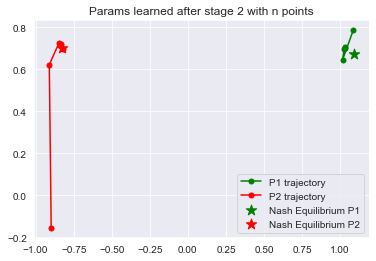

In [17]:
x_nash_p1 = [theta_PO_1[0]]
y_nash_p1 = [theta_PO_1[1]]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium P1', marker='*', color='g', s=120)

x_nash_p2 = theta_PO_2[0]
y_nash_p2 = theta_PO_2[1]
plt.scatter(x_nash_p2,y_nash_p2,
            label='Nash Equilibrium P2', marker='*', color='r', s=120)

x2 = theta_final_p1[:, 0]
y2 = theta_final_p1[:, 1]
plt.plot(x2[1:],y2[1:],
         label='P1 trajectory', marker='o', color='g', markersize=5)

x3 = theta_final_p2[:, 0]
y3 = theta_final_p2[:, 1]
plt.plot(x3[1:],y3[1:],
         label='P2 trajectory', marker='o', color='r', markersize=5)

plt.legend()
plt.title("Params learned after stage 2 with n points")
plt.show()

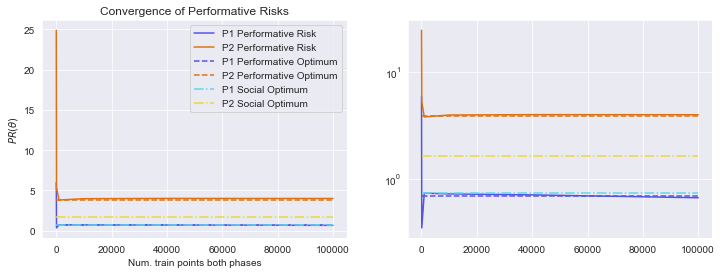

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(num_rounds_lst, p1_risks,
         color='#5553E6', label='P1 Performative Risk')
plt.plot(num_rounds_lst, p2_risks,
         color='#E07110', label='P2 Performative Risk')
plt.plot(num_rounds_lst, [PO_1 for i in num_rounds_lst],
         '--', color='#5553E6', label='P1 Performative Optimum')
plt.plot(num_rounds_lst, [PO_2 for i in num_rounds_lst],
         '--', color='#E07110', label='P2 Performative Optimum')
plt.plot(num_rounds_lst, [SO_1 for i in num_rounds_lst],
         '-.', color='#5BD9EB', label='P1 Social Optimum')
plt.plot(num_rounds_lst, [SO_2 for i in num_rounds_lst],
         '-.', color='#EBD839', label='P2 Social Optimum')
plt.xlabel("Num. train points both phases")
plt.ylabel(r"$PR(\theta)$")
plt.title("Convergence of Performative Risks")
plt.legend()

plt.subplot(1,2,2)
plt.semilogy(num_rounds_lst, p1_risks,
         color='#5553E6', label='P1 Performative Risk')
plt.semilogy(num_rounds_lst, p2_risks,
         color='#E07110', label='P2 Performative Risk')
plt.semilogy(num_rounds_lst, [PO_1 for i in num_rounds_lst],
         '--', color='#5553E6', label='P1 Performative Optimum')
plt.semilogy(num_rounds_lst, [PO_2 for i in num_rounds_lst],
         '--', color='#E07110', label='P2 Performative Optimum')
plt.semilogy(num_rounds_lst, [SO_1 for i in num_rounds_lst],
         '-.', color='#5BD9EB', label='P1 Social Optimum')
plt.semilogy(num_rounds_lst, [SO_2 for i in num_rounds_lst],
         '-.', color='#EBD839', label='P2 Social Optimum')
plt.ylabel(r"\log(PR(\theta))")
plt.show()